In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as graph
import seaborn as sns
import cartopy
import cartopy.crs as ccrs

from tqdm import tqdm
import swifter

from osgeo import ogr, osr, gdal
# from joblib import Parallel, delayed

tqdm.pandas()
import xarray as xr
from global_land_mask import globe
import geopandas as gpd
import geoplot

from datetime import date
today_date = date.today().strftime("%b_%d").lower()
import os

from convertbng.util import convert_bng, convert_lonlat
import utm

import shapefile as shp
from shapely.geometry import Point, Polygon, MultiPolygon
import imageio
import matplotlib as mpl

# Nick Watersheds

In [2]:
canada_lakes = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/hydrolakes_ahi_bsm_sapna_lake_caracteristics_aug_26.csv')
print(len(canada_lakes))

canada_lakes.drop_duplicates(inplace = True)

print(len(canada_lakes))
display(canada_lakes.head())

24209
24209


,Hylak_id,wby_name,Country,Continent,lake_area_km2,mean_depth_m,lake_elevation_(m),longitude,latitude,dataset,surface_area_ha,max_depth_m,made_up_code
0,NaN,Bowlby P.,NaN,NaN,0.001,1.5,201.0,-80.261111,42.793056,ahi_bsm,NaN,NaN,NaN
1,NaN,"B, L.",NaN,NaN,0.001,NaN,326.0,-80.200000,43.450000,ahi_bsm,NaN,NaN,NaN
2,NaN,"H-A, L.",NaN,NaN,0.001,NaN,332.0,-80.166667,43.500000,ahi_bsm,NaN,NaN,NaN
3,NaN,Eby Ph.,NaN,NaN,0.002,1.2,320.0,-80.163333,48.032500,ahi_bsm,NaN,NaN,NaN
4,NaN,Vances L.,NaN,NaN,0.002,1.6,265.0,-81.375000,44.233889,ahi_bsm,NaN,NaN,NaN


In [3]:
# ildf
gpd_canada_lakes = gpd.GeoDataFrame(canada_lakes, 
                                    geometry=gpd.points_from_xy(canada_lakes['longitude'], canada_lakes['latitude']))
gpd_canada_lakes.head()

,Hylak_id,wby_name,Country,Continent,lake_area_km2,mean_depth_m,lake_elevation_(m),longitude,latitude,dataset,surface_area_ha,max_depth_m,made_up_code,geometry
0,NaN,Bowlby P.,NaN,NaN,0.001,1.5,201.0,-80.261111,42.793056,ahi_bsm,NaN,NaN,NaN,POINT (-80.26111 42.79306)
1,NaN,"B, L.",NaN,NaN,0.001,NaN,326.0,-80.200000,43.450000,ahi_bsm,NaN,NaN,NaN,POINT (-80.20000 43.45000)
2,NaN,"H-A, L.",NaN,NaN,0.001,NaN,332.0,-80.166667,43.500000,ahi_bsm,NaN,NaN,NaN,POINT (-80.16667 43.50000)
3,NaN,Eby Ph.,NaN,NaN,0.002,1.2,320.0,-80.163333,48.032500,ahi_bsm,NaN,NaN,NaN,POINT (-80.16333 48.03250)
4,NaN,Vances L.,NaN,NaN,0.002,1.6,265.0,-81.375000,44.233889,ahi_bsm,NaN,NaN,NaN,POINT (-81.37500 44.23389)


In [28]:
nick_shapefile = gpd.read_file('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Nick_Mandrak/Canada_shapefiles/Canada_watersheds_hydrolakes_our_lake_counts_pop_density.shp')
print(len(nick_shapefile))
nick_shapefile.head()

991


,WSCSSDA,TWS_Area_m,out_lakes_,hydro_lake,mean_pop_d,geometry
0,08JD,6.266462e+09,27.0,116.0,0.306156,"POLYGON ((-125.41910 55.11623, -125.41885 55.1..."
1,05AK,5.335010e+09,2.0,31.0,4.017055,"POLYGON ((-109.89815 50.92035, -109.89509 50.9..."
2,06CE,4.591652e+09,5.0,872.0,0.359558,"POLYGON ((-105.14596 56.98348, -105.14677 56.9..."
3,07HE,6.463431e+09,3.0,121.0,0.160877,"POLYGON ((-116.42664 57.94598, -116.42025 57.9..."
4,06CD,1.911540e+10,60.0,3054.0,0.280647,"POLYGON ((-104.27707 56.09364, -104.27596 56.0..."


In [30]:
watershed_counts = pd.Series(nick_shapefile['out_lakes_'].values)
watershed_counts.replace(0, 0.1, inplace=True)
labels = ['0', '1-5', '6-10', '11-30', '30-50', '50-100', '>100']

cut_watershed_counts = pd.cut(watershed_counts, bins=[0, 1, 5, 10, 30, 50, 100, 900], labels=labels)
nick_shapefile['binned_our_counts'] = cut_watershed_counts

nick_shapefile.head(10)

,WSCSSDA,TWS_Area_m,out_lakes_,hydro_lake,mean_pop_d,geometry,binned_our_counts
0,08JD,6.266462e+09,27.0,116.0,0.306156,"POLYGON ((-125.41910 55.11623, -125.41885 55.1...",11-30
1,05AK,5.335010e+09,2.0,31.0,4.017055,"POLYGON ((-109.89815 50.92035, -109.89509 50.9...",1-5
2,06CE,4.591652e+09,5.0,872.0,0.359558,"POLYGON ((-105.14596 56.98348, -105.14677 56.9...",1-5
3,07HE,6.463431e+09,3.0,121.0,0.160877,"POLYGON ((-116.42664 57.94598, -116.42025 57.9...",1-5
4,06CD,1.911540e+10,60.0,3054.0,0.280647,"POLYGON ((-104.27707 56.09364, -104.27596 56.0...",50-100
5,08JC,8.817841e+09,71.0,248.0,2.473939,"POLYGON ((-123.05382 54.02521, -123.05300 54.0...",50-100
6,07HD,1.534211e+09,0.1,19.0,0.149339,"POLYGON ((-117.01620 57.83971, -117.01000 57.8...",0
7,05AH,6.343748e+09,10.0,55.0,2.516894,"POLYGON ((-109.83156 49.91647, -109.83073 49.9...",6-10
8,07HF,3.472724e+09,3.0,34.0,0.494176,"POLYGON ((-116.04024 58.35171, -116.04050 58.3...",1-5
9,05AG,3.325150e+09,6.0,17.0,6.288850,"POLYGON ((-111.70162 49.93916, -111.70446 49.9...",6-10


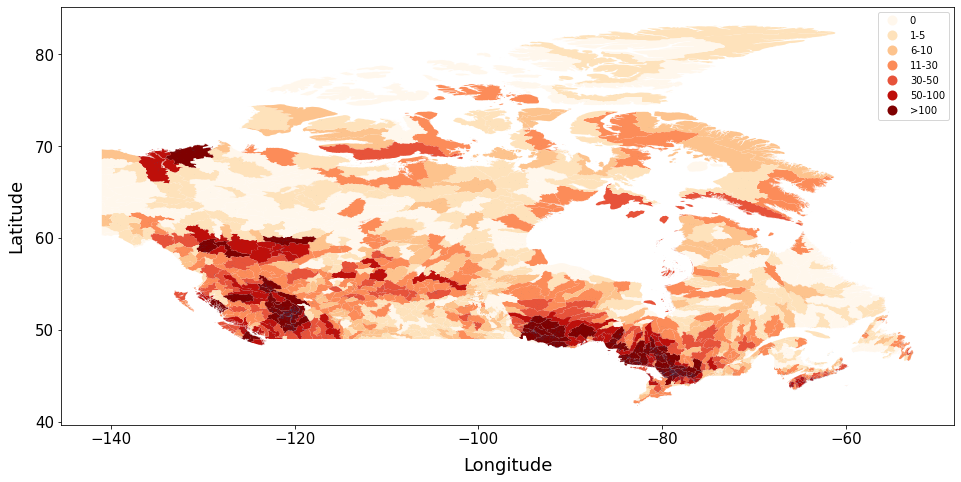

In [31]:
fig, ax = graph.subplots(figsize=(16, 9))

nick_shapefile.plot(column='binned_our_counts', legend=True, cmap='OrRd', figsize=(16, 9), zorder=1, ax=ax)
gpd_canada_lakes.plot(ax = ax, zorder=2, markersize=0.0001)
graph.xlabel('Longitude', fontsize = 18, labelpad=10)
graph.ylabel('Latitude', fontsize = 18, labelpad=10)
graph.xticks(fontsize = 15)
graph.yticks(fontsize = 15)
# fig.savefig('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Graphs/canadian_lakes_watershed_density.png', bbox_inches='tight')
graph.show()

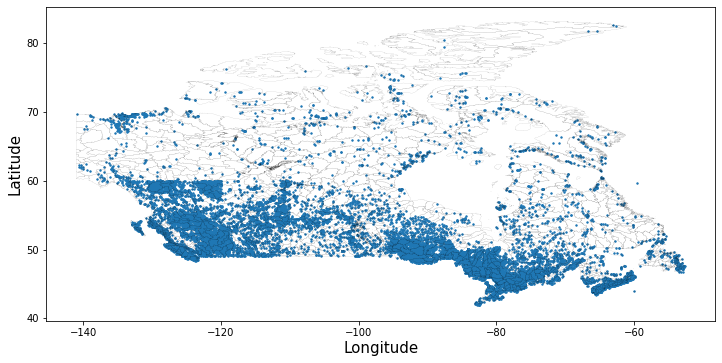

In [32]:
fig, ax = graph.subplots(figsize=(12, 9))

nick_shapefile.boundary.plot(figsize=(12, 9), zorder=2, edgecolor='black', linewidth = 0.05, ax=ax)
gpd_canada_lakes.plot(ax = ax, zorder=1, markersize=2)
graph.xlabel('Longitude', fontsize = 15, labelpad=3)
graph.ylabel('Latitude', fontsize=15)
# fig.savefig('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Graphs/canadian_lakes_watershed_borders_markers.png', 
#             bbox_inches='tight')
graph.show()

In [33]:
watershed_counts = pd.Series(nick_shapefile['hydro_lake'].values)
watershed_counts.replace(0, 0.1, inplace=True)
labels = ['0', '1-100', '101-500', '501-1000', '1001-5000', '5001-10000', '>10000']

cut_watershed_counts = pd.cut(watershed_counts, bins=[0, 1, 100, 500, 1000, 5000, 10000, 2000000], labels=labels)
nick_shapefile['binned_hydro_counts'] = cut_watershed_counts

nick_shapefile.head(10)

,WSCSSDA,TWS_Area_m,out_lakes_,hydro_lake,mean_pop_d,geometry,binned_our_counts,binned_hydro_counts
0,08JD,6.266462e+09,27.0,116.0,0.306156,"POLYGON ((-125.41910 55.11623, -125.41885 55.1...",11-30,101-500
1,05AK,5.335010e+09,2.0,31.0,4.017055,"POLYGON ((-109.89815 50.92035, -109.89509 50.9...",1-5,1-100
2,06CE,4.591652e+09,5.0,872.0,0.359558,"POLYGON ((-105.14596 56.98348, -105.14677 56.9...",1-5,501-1000
3,07HE,6.463431e+09,3.0,121.0,0.160877,"POLYGON ((-116.42664 57.94598, -116.42025 57.9...",1-5,101-500
4,06CD,1.911540e+10,60.0,3054.0,0.280647,"POLYGON ((-104.27707 56.09364, -104.27596 56.0...",50-100,1001-5000
5,08JC,8.817841e+09,71.0,248.0,2.473939,"POLYGON ((-123.05382 54.02521, -123.05300 54.0...",50-100,101-500
6,07HD,1.534211e+09,0.1,19.0,0.149339,"POLYGON ((-117.01620 57.83971, -117.01000 57.8...",0,1-100
7,05AH,6.343748e+09,10.0,55.0,2.516894,"POLYGON ((-109.83156 49.91647, -109.83073 49.9...",6-10,1-100
8,07HF,3.472724e+09,3.0,34.0,0.494176,"POLYGON ((-116.04024 58.35171, -116.04050 58.3...",1-5,1-100
9,05AG,3.325150e+09,6.0,17.0,6.288850,"POLYGON ((-111.70162 49.93916, -111.70446 49.9...",6-10,1-100


TypeError: unsupported operand type(s) for /: 'str' and 'float'

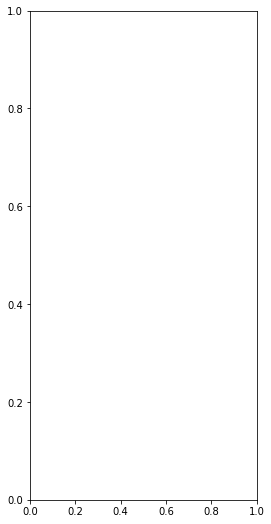

In [37]:
fig, ax = graph.subplots(figsize=(16, 9))

nick_shapefile.plot(column='binned_hydro_counts', legend=True, cmap='OrRd', zorder=2, ax=ax)
gpd_canada_lakes.plot(ax = ax, zorder=1, markersize=0.0001)
graph.xlabel('Longitude', fontsize=13, labelpad=3)
graph.ylabel('Latitude', fontsize=13)
# fig.savefig('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Graphs/canadian_watershed_fish_locations_density.png', 
#             bbox_inches='tight')
graph.show()

# Population Density

In [16]:
def create_square(lon,lat):
    result= Polygon([(lon-0.5,lat-0.5),(lon-0.5,lat+0.5),(lon+0.5,lat+0.5),(lon+0.5,lat-0.5),(lon-0.5,lat-0.5)])
    return result

In [10]:
ds = gdal.Open('/mnt/c/Users/imrit/Downloads/Population_density/gpw_v4_population_density_adjusted_to_2015_unwpp_country_totals_rev11_2020_1_deg.tif')
data = ds.ReadAsArray()
data.shape

(180, 360)

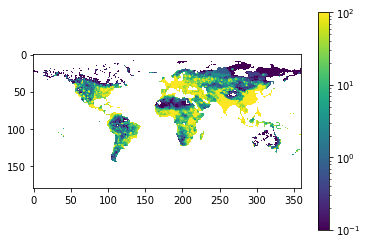

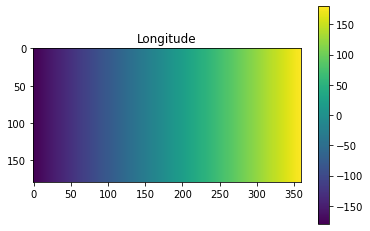

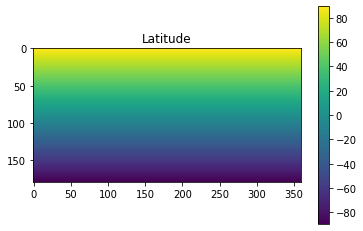

In [11]:
lat = np.linspace(89.5,-89.5,180)
lon = np.linspace(-179.5,179.5, 360)
longrid,latgrid = np.meshgrid(lon,lat)

graph.imshow(data,norm=mpl.colors.LogNorm(vmin=0.1,vmax=100))
graph.colorbar()
graph.show()
graph.imshow(longrid)
graph.title('Longitude')
graph.colorbar()
graph.show()
graph.title('Latitude')
graph.imshow(latgrid)
graph.colorbar()
graph.show()

In [17]:
df_pop_den = pd.DataFrame({'lon': longrid.flatten(), 'lat': latgrid.flatten(),'popdens': data.flatten()})
df_pop_den = df_pop_den.loc[(df_pop_den['lon'] < -29) & (df_pop_den['lat'] > 30)]

display(df_pop_den.head())
print(df_pop_den.shape)

,lon,lat,popdens
0,-179.5,89.5,-3.402823e+38
1,-178.5,89.5,-3.402823e+38
2,-177.5,89.5,-3.402823e+38
3,-176.5,89.5,-3.402823e+38
4,-175.5,89.5,-3.402823e+38


(9060, 3)


In [13]:
popden_list_of_points = gpd.points_from_xy(df_pop_den.lon, df_pop_den.lat)

gpd_pop_den = gpd.GeoSeries(popden_list_of_points)
print(len(gpd_pop_den))
gpd_pop_den

9060


0       POINT (-179.50000 89.50000)
1       POINT (-178.50000 89.50000)
2       POINT (-177.50000 89.50000)
3       POINT (-176.50000 89.50000)
4       POINT (-175.50000 89.50000)
                   ...             
9055     POINT (-33.50000 30.50000)
9056     POINT (-32.50000 30.50000)
9057     POINT (-31.50000 30.50000)
9058     POINT (-30.50000 30.50000)
9059     POINT (-29.50000 30.50000)
Length: 9060, dtype: geometry

In [18]:
gdf = gpd.GeoDataFrame(df_pop_den,geometry = [create_square(lon,lat) for lon,lat in zip(df_pop_den.lon,df_pop_den.lat)])
gdf

,lon,lat,popdens,geometry
0,-179.5,89.5,-3.402823e+38,"POLYGON ((-180.00000 89.00000, -180.00000 90.0..."
1,-178.5,89.5,-3.402823e+38,"POLYGON ((-179.00000 89.00000, -179.00000 90.0..."
2,-177.5,89.5,-3.402823e+38,"POLYGON ((-178.00000 89.00000, -178.00000 90.0..."
3,-176.5,89.5,-3.402823e+38,"POLYGON ((-177.00000 89.00000, -177.00000 90.0..."
4,-175.5,89.5,-3.402823e+38,"POLYGON ((-176.00000 89.00000, -176.00000 90.0..."
...,...,...,...,...
21386,-33.5,30.5,-3.402823e+38,"POLYGON ((-34.00000 30.00000, -34.00000 31.000..."
21387,-32.5,30.5,-3.402823e+38,"POLYGON ((-33.00000 30.00000, -33.00000 31.000..."
21388,-31.5,30.5,-3.402823e+38,"POLYGON ((-32.00000 30.00000, -32.00000 31.000..."
21389,-30.5,30.5,-3.402823e+38,"POLYGON ((-31.00000 30.00000, -31.00000 31.000..."


In [23]:
%%time
nrows = len(nick_shapefile)

for i, row in tqdm(nick_shapefile.iterrows()):
    poly = row.geometry
    if isinstance(poly,MultiPolygon):
        density_list = []
        for p in list(poly):
            ind = gdf['geometry'].intersects(p)
            density_list.extend(gdf.loc[ind,'popdens'].tolist())
        density = np.mean(density_list)
    else:
        ind = gdf['geometry'].intersects(poly)
        density = gdf.loc[ind,'popdens'].mean()
    nick_shapefile.loc[i,'mean_pop_density'] = density

991it [04:28,  3.69it/s]

CPU times: user 4min 21s, sys: 1.11 s, total: 4min 22s
Wall time: 4min 28s


In [27]:
# nick_shapefile.drop(columns = ['binned_our_counts', 'binned_hydro_counts'], inplace = True)
# nick_shapefile.to_file('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Nick_Mandrak/Canada_shapefiles/Canada_watersheds_hydrolakes_our_lake_counts_pop_density.shp', 
#                        index = False)

/tmp/ipykernel_254/2088382765.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  nick_shapefile.to_file('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Nick_Mandrak/Canada_shapefiles/Canada_watersheds_hydrolakes_our_lake_counts_pop_density.shp',


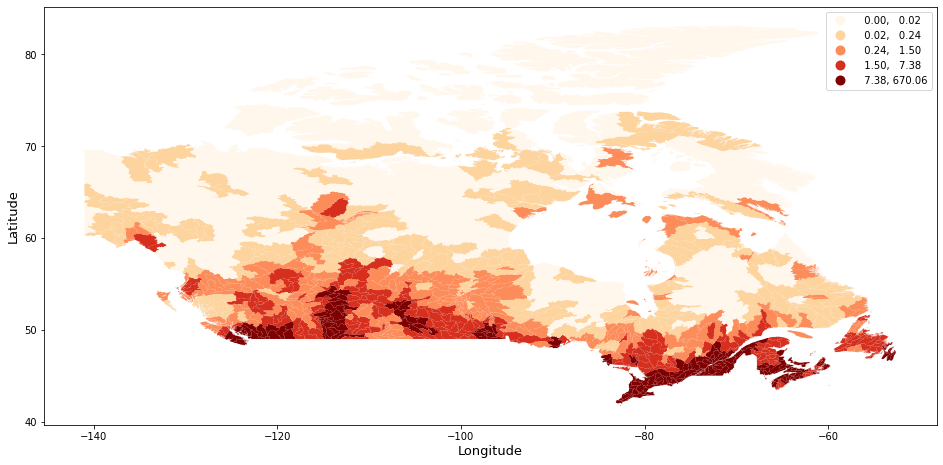

In [38]:
fig, ax = graph.subplots(figsize=(16, 9))

nick_shapefile.plot(column='mean_pop_d', legend=True, cmap='OrRd', scheme = 'quantiles', zorder=2, ax=ax)
gpd_canada_lakes.plot(ax = ax, zorder=1, markersize=0.0001)
graph.xlabel('Longitude', fontsize=13, labelpad=3)
graph.ylabel('Latitude', fontsize=13)
# fig.savefig('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Graphs/canadian_watershed_fish_locations_density.png', 
#             bbox_inches='tight')
graph.show()

<AxesSubplot:>

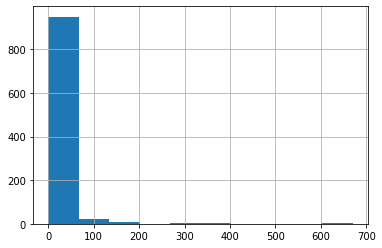

In [36]:
nick_shapefile['mean_pop_d'].hist()